In [2]:
import pickle 
import numpy as np
import torch 
import pandas as pd
import rootutils
import json
import os 
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(context ='paper',style='whitegrid')
rootutils.setup_root('/idiap/temp/pvuillecard/projects/gaze_pretrain/notebooks', indicator=".project-root", pythonpath=True)
# plot the results 

from gaze_module.utils.metrics import compute_gaze_results
from gaze_module.utils.metrics_utils import cartesial2spherical, spherical2cartesial,compute_angular_error_cartesian

data_dir = '/idiap/temp/pvuillecard/datasets/'

In [3]:
def plot_gaze_distribution(image_db, gaze_key, if_other= True):
    gaze_distribution = []
    for image in image_db.values():
        if if_other:
            gaze_dir = torch.tensor(image['other'][gaze_key]).unsqueeze(0)
        else:
            gaze_dir = torch.tensor(image[gaze_key]).unsqueeze(0)
            
        gaze_dir = cartesial2spherical(gaze_dir)[0]*180/np.pi
        gaze_distribution.append(gaze_dir.numpy().tolist())
    print(gaze_distribution[:10])
    gaze_distribution = pd.DataFrame(gaze_distribution, columns=['Yaw','Pitch'])

    return gaze_distribution

def plot_gaze_yaw_z_distribution(image_db, gaze_key, if_other= True):
    gaze_distribution = []
    for image in image_db.values():
        if if_other:
            gaze_dir = torch.tensor(image['other'][gaze_key]).unsqueeze(0)
        else:
            gaze_dir = torch.tensor(image[gaze_key]).unsqueeze(0)
        
        z = gaze_dir[0].numpy()[2]
        gaze_dir = cartesial2spherical(gaze_dir).numpy()[0]*180/np.pi
        yaw = gaze_dir[0] 
        gaze_distribution.append([yaw, z])
    
    gaze_distribution = pd.DataFrame(gaze_distribution, columns=['Yaw','Z'])

    return gaze_distribution

def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

[[72.25607010432184, -14.344027708698185], [72.59603220630908, -14.630503464859698], [75.86165302373622, -15.154968671056409], [78.49417947961271, -15.55354272015631], [80.42006655616854, -15.914094002239684], [84.04805420110067, -16.42745765411633], [84.96924162211974, -16.683290819764114], [88.17881478076107, -17.41917292483385], [89.89833250853334, -17.887671167529337], [94.53596834494725, -18.436803851655352]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[15.071322697156257, -78.50169577266188], [10.516412895950781, -77.07357394310694], [8.39806823860174, -75.10720079402654], [7.8741992975901915, -74.69471531295814], [8.782632210706925, -73.28719301628863], [6.061522261161641, -72.25384945950788], [4.90142406477078, -70.32062069095173], [5.293498594681965, -68.84707468827081], [5.017113083604373, -68.89825199645986], [5.9024091134482415, -67.3631610242951]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-35.769752502441406, -29.64483642578125], [20.50615882873535, -40.80032730102539], [-20.236867904663086, -29.621919631958008], [18.592479705810547, 10.12989330291748], [41.613922119140625, -0.6130648851394653], [32.58983612060547, 7.683363914489746], [2.8418707847595215, 2.578310012817383], [-60.41839599609375, 23.64596939086914], [28.493192672729492, -31.352251052856445], [-24.648643493652344, 15.275054931640625]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-20.500186920166016, 21.731008529663086], [-10.448698043823242, 11.101594924926758], [-9.672285079956055, 12.180270195007324], [-9.450647354125977, 12.974776268005371], [14.595841407775879, 14.028498649597168], [12.718172073364258, 14.747612953186035], [11.541481018066406, 15.961816787719727], [10.833230018615723, 17.655231475830078], [10.606649398803711, 18.781076431274414], [-6.195262908935547, 11.39775562286377]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[13.695579528808594, -8.293787002563477], [32.14409255981445, -3.238736391067505], [44.490760803222656, -4.033905506134033], [41.08781814575195, -0.7899865508079529], [30.1318416595459, 0.1985604465007782], [21.158720016479492, -1.837993860244751], [8.393701553344727, -1.0775749683380127], [-7.287065029144287, -1.782336711883545], [-14.308656692504883, -2.1835920810699463], [-17.269983291625977, -2.5554771423339844]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[18.098316192626953, -3.1295392513275146], [4.931249141693115, -18.386011123657227], [13.409339904785156, -2.4825832843780518], [2.151256799697876, -13.429819107055664], [14.820130348205566, -4.61517858505249], [16.415550231933594, -17.33106803894043], [2.050858736038208, -5.897305488586426], [-12.791028022766113, -15.243738174438477], [9.392122268676758, -14.829168319702148], [-0.32560208439826965, -4.629684925079346]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


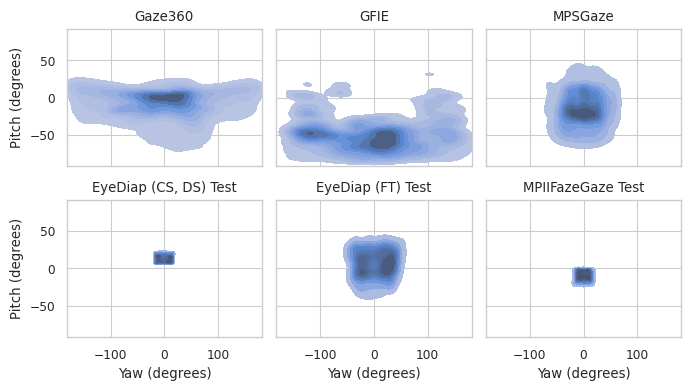

In [3]:
# plot the gaze distribution of different datasets

fig, ax = plt.subplots(2, 3, figsize=(7,4) , sharex=True, sharey=True)
ax = ax.flatten()
with open(os.path.join(data_dir,'Gaze360','gaze360_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_dir')
gaze_distribution = gaze_distribution.sample(50000)
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[0],fill=True)
ax[0].set_title('Gaze360')

with open(os.path.join(data_dir,'GFIE','gfie_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_direction')
gaze_distribution = gaze_distribution.sample(50000)
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[1],fill=True)
ax[1].set_title('GFIE')

# with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360.pkl', 'rb') as f:
#     pred_gaze = pickle.load(f)
# gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
# gaze_distribution = gaze_distribution.sample(50000)
# sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[2],fill=True)
# ax[2].set_title('GazeFollow pseudo z gaze360')

# with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie.pkl', 'rb') as f:
#     pred_gaze = pickle.load(f)
# gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
# gaze_distribution = gaze_distribution.sample(50000)
# sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[3],fill=True)
# ax[3].set_title('GazeFollow pseudo z gfie')

with open(os.path.join(data_dir,'MPSGaze','mpsgaze_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
for k,v in image_db.items():
    image_db[k]['other']['gaze_direction'] = spherical2cartesial(torch.tensor(v['other']['gaze_pitch_yaw'][::-1]).unsqueeze(0)).numpy().tolist()[0]
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_direction')
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[2],fill=True)
ax[2].set_title('MPSGaze')

with open(os.path.join(data_dir,'Eyediap','eyediap_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
# filter only test split
image_db = {k:v for k,v in image_db.items() if v['split'] in ['test']}

# filter the gaze direction
image_db_CS = {k:v for k,v in image_db.items() if v['task'] in ['CS','DS']}
gaze_distribution = plot_gaze_distribution(image_db_CS, 'gaze_direction')
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[3],fill=True)
ax[3].set_title('EyeDiap (CS, DS) Test')


image_db_ft = {k:v for k,v in image_db.items() if (v['task'] in ['FT']) and (v['static'] in ['S'])}
gaze_distribution = plot_gaze_distribution(image_db_ft, 'gaze_direction')
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[4],fill=True)
ax[4].set_title('EyeDiap (FT) Test')

with open(os.path.join(data_dir,'MPIIFace','mpiiface_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
# filter the gaze direction
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_vector')
sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[5],fill=True)
ax[5].set_title('MPIIFazeGaze Test')

#ax[5].axis('off')
for axe in ax:
    axe.set_xlabel('Yaw (degrees)')
    axe.set_ylabel('Pitch (degrees)')
#plt.tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_xlim(-182,182)
ax[1].set_ylim(-92,92)
plt.tight_layout()
fig.savefig('results/gaze_distribution_kde.png', dpi=300)
plt.show()


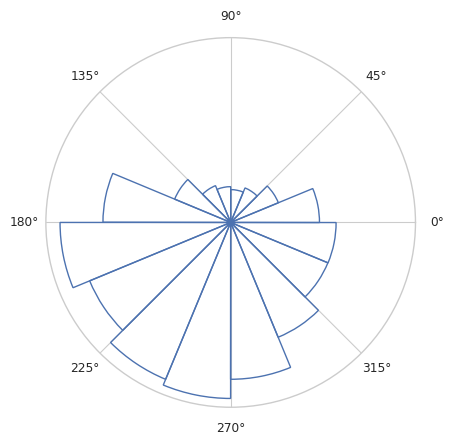

In [41]:
with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360_gaze360v.pkl', 'rb') as f:
    pred_gaze = pickle.load(f)

angles = []
for k,v in pred_gaze.items():
    x = v['gaze_vector_pred'][0]
    y = v['gaze_vector_pred'][1]
    angle = np.arctan2(y, x)
    angles.append(angle)
angles = np.array(angles)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))

# Visualise by area of bins
circular_hist(ax, angles)
fig.savefig('results/gaze_distribution_gazefollow.png', dpi=300)

[[72.25607010432184, -14.344027708698185], [72.59603220630908, -14.630503464859698], [75.86165302373622, -15.154968671056409], [78.49417947961271, -15.55354272015631], [80.42006655616854, -15.914094002239684], [84.04805420110067, -16.42745765411633], [84.96924162211974, -16.683290819764114], [88.17881478076107, -17.41917292483385], [89.89833250853334, -17.887671167529337], [94.53596834494725, -18.436803851655352]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[15.071322697156257, -78.50169577266188], [10.516412895950781, -77.07357394310694], [8.39806823860174, -75.10720079402654], [7.8741992975901915, -74.69471531295814], [8.782632210706925, -73.28719301628863], [6.061522261161641, -72.25384945950788], [4.90142406477078, -70.32062069095173], [5.293498594681965, -68.84707468827081], [5.017113083604373, -68.89825199645986], [5.9024091134482415, -67.3631610242951]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-35.769752502441406, -29.64483642578125], [20.50615882873535, -40.80032730102539], [-20.236867904663086, -29.621919631958008], [18.592479705810547, 10.12989330291748], [41.613922119140625, -0.6130648851394653], [32.58983612060547, 7.683363914489746], [2.8418707847595215, 2.578310012817383], [-60.41839599609375, 23.64596939086914], [28.493192672729492, -31.352251052856445], [-24.648643493652344, 15.275054931640625]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-20.500186920166016, 21.731008529663086], [-10.448698043823242, 11.101594924926758], [-9.672285079956055, 12.180270195007324], [-9.450647354125977, 12.974776268005371], [14.595841407775879, 14.028498649597168], [12.718172073364258, 14.747612953186035], [11.541481018066406, 15.961816787719727], [10.833230018615723, 17.655231475830078], [10.606649398803711, 18.781076431274414], [-6.195262908935547, 11.39775562286377]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[13.695579528808594, -8.293787002563477], [32.14409255981445, -3.238736391067505], [44.490760803222656, -4.033905506134033], [41.08781814575195, -0.7899865508079529], [30.1318416595459, 0.1985604465007782], [21.158720016479492, -1.837993860244751], [8.393701553344727, -1.0775749683380127], [-7.287065029144287, -1.782336711883545], [-14.308656692504883, -2.1835920810699463], [-17.269983291625977, -2.5554771423339844]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[18.098316192626953, -3.1295392513275146], [4.931249141693115, -18.386011123657227], [13.409339904785156, -2.4825832843780518], [2.151256799697876, -13.429819107055664], [14.820130348205566, -4.61517858505249], [16.415550231933594, -17.33106803894043], [2.050858736038208, -5.897305488586426], [-12.791028022766113, -15.243738174438477], [9.392122268676758, -14.829168319702148], [-0.32560208439826965, -4.629684925079346]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


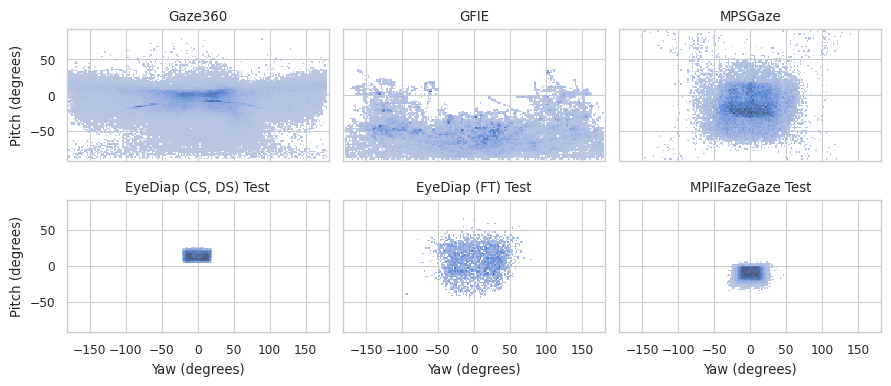

In [4]:
# plot the gaze distribution of different datasets

fig, ax = plt.subplots(2, 3 , figsize=(9,4) ,sharex=True, sharey=True)
ax = ax.flatten()
with open(os.path.join(data_dir,'Gaze360','gaze360_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_dir')
#gaze_distribution = gaze_distribution.sample(50000)
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[0],cbar=False,binwidth=2)
ax[0].set_title('Gaze360')

with open(os.path.join(data_dir,'GFIE','gfie_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_direction')
#gaze_distribution = gaze_distribution.sample(50000)
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[1],cbar=False,binwidth=2)
ax[1].set_title('GFIE')

# # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360.pkl', 'rb') as f:
# #     pred_gaze = pickle.load(f)
# # gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
# # gaze_distribution = gaze_distribution.sample(50000)
# # sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[2],fill=True)
# # ax[2].set_title('GazeFollow pseudo z gaze360')

# # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie.pkl', 'rb') as f:
# #     pred_gaze = pickle.load(f)
# # gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
# # gaze_distribution = gaze_distribution.sample(50000)
# # sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[3],fill=True)
# # ax[3].set_title('GazeFollow pseudo z gfie')

with open(os.path.join(data_dir,'MPSGaze','mpsgaze_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
for k,v in image_db.items():
    image_db[k]['other']['gaze_direction'] = spherical2cartesial(torch.tensor(v['other']['gaze_pitch_yaw'][::-1]).unsqueeze(0)).numpy().tolist()[0]
gaze_distribution = plot_gaze_distribution(image_db, 'gaze_direction')
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[2],cbar=False,binwidth=2)
ax[2].set_title('MPSGaze')

with open(os.path.join(data_dir,'Eyediap','eyediap_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
# filter only test split
image_db = {k:v for k,v in image_db.items() if v['split'] in ['test']}

# filter the gaze direction
image_db_CS = {k:v for k,v in image_db.items() if v['task'] in ['CS','DS']}
gaze_distribution = plot_gaze_distribution(image_db_CS, 'gaze_direction')
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[3],cbar=False,binwidth=2)
ax[3].set_title('EyeDiap (CS, DS) Test')


# filter the gaze direction
image_db_ft = {k:v for k,v in image_db.items() if (v['task'] in ['FT']) and (v['static'] in ['S'])}
gaze_distribution = plot_gaze_distribution(image_db_ft, 'gaze_direction')
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[4],cbar=False,binwidth=2)
ax[4].set_title('EyeDiap (FT) Test')

with open(os.path.join(data_dir,'MPIIFace','mpiiface_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
# filter the gaze direction

gaze_distribution = plot_gaze_distribution(image_db, 'gaze_vector')
sns.histplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[5],cbar=False,binwidth=2)
ax[5].set_title('MPIIFazeGaze Test')

#ax[5].axis('off')
for axe in ax:
    axe.set_aspect('equal', adjustable='box')
    axe.set_xticks([-150,-100,-50 , 0, 50, 100, 150])
    axe.set_yticks([ -50, 0, 50])
    axe.set_xlabel('Yaw (degrees)')
    axe.set_ylabel('Pitch (degrees)')

#plt.tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_xlim(-182,182)
ax[1].set_ylim(-92,92)
plt.tight_layout()
fig.savefig('results/gaze_distribution.png', dpi=300)
plt.show()

              Yaw         Z
181521  54.445941 -0.576986
186694 -40.416011 -0.754209
15878   -9.159162 -0.986777
40976  -28.606355 -0.876157
75866  -30.364588 -0.862815
...           ...       ...
138225  41.421810 -0.741107
119875  49.323383 -0.649141
108545  24.896935 -0.858466
92961   15.206337 -0.963604
193019  34.412314 -0.804903

[50000 rows x 2 columns]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

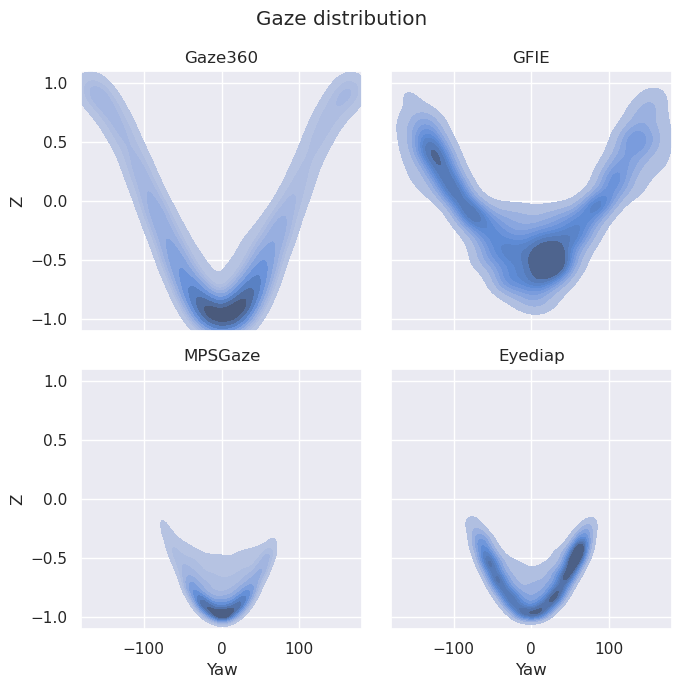

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(7,7) , sharex=True, sharey=True)
fig.suptitle('Gaze distribution') 
ax = ax.flatten()
i = 0 

with open(os.path.join(data_dir,'Gaze360','gaze360_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_yaw_z_distribution(image_db, 'gaze_dir')
gaze_distribution = gaze_distribution.sample(50000)
print(gaze_distribution)
sns.kdeplot(gaze_distribution, x="Yaw", y="Z", ax=ax[i],fill=True)
ax[i].set_title('Gaze360')
i+=1


with open(os.path.join(data_dir,'GFIE','gfie_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_yaw_z_distribution(image_db, 'gaze_direction')
gaze_distribution = gaze_distribution.sample(50000)
sns.kdeplot(gaze_distribution, x="Yaw", y="Z", ax=ax[i],fill=True)
ax[i].set_title('GFIE')
i+=1

with open(os.path.join(data_dir,'MPSGaze','mpsgaze_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
for k,v in image_db.items():
    image_db[k]['other']['gaze_direction'] = spherical2cartesial(torch.tensor(v['other']['gaze_pitch_yaw'][::-1]).unsqueeze(0)).numpy().tolist()[0]
gaze_distribution = plot_gaze_yaw_z_distribution(image_db, 'gaze_direction')
sns.kdeplot(gaze_distribution, x="Yaw", y="Z", ax=ax[i],fill=True)
ax[i].set_title('MPSGaze')
i+=1

with open(os.path.join(data_dir,'Eyediap','eyediap_image_database.pkl'), 'rb') as f:
    image_db = pickle.load(f)
gaze_distribution = plot_gaze_yaw_z_distribution(image_db, 'gaze_direction')
sns.kdeplot(gaze_distribution, x="Yaw", y="Z",  ax=ax[i],fill=True)
ax[i].set_title('Eyediap')
i+=1

#ax[5].axis('off')
plt.tight_layout()
ax[1].set_xlim(-181,181)
ax[1].set_ylim(-1.1,1.1)
fig.savefig('results/gaze_distribution_z.png', dpi=300)
plt.show()

[[-163.3881695161865, -6.197603633238379], [14.195561474998522, -38.879025155096095], [-15.155836308910768, -14.431763891950295], [-75.57827503966514, -47.113082516812284], [177.13196545699387, -14.729725173152628], [-160.1133168633578, -18.62878058367343], [175.86898035699164, -21.494752853979833], [-142.2829385962045, -18.596513599168215], [57.167967959148996, -33.69495316676698], [3.634566220649689, -77.92668328066003]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-135.13652170499566, -15.00005386654069], [11.064240747378438, -32.25090662405571], [-13.268019043417622, -12.729958018930725], [-73.57601494369003, -46.837522831665915], [168.9523294886246, -45.19547178374507], [-150.69693189668752, -25.874307231997157], [175.5915713959989, -22.792105162940462], [-148.64314891841593, -15.971210385498024], [43.55094742392617, -28.667822217492372], [2.854421371632053, -74.76852114206285]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-103.19207636020556, -20.29545384375138], [18.358420404784564, -46.00058481746175], [-63.24430906314356, -41.313479807626855], [-67.82239016475268, -45.83022593393147], [124.1203055320618, -77.05286134884493], [-129.76593666800738, -37.297940230018845], [39.16359079959764, -73.84615509815656], [-140.1367233599374, -19.418919164218554], [49.36073788066586, -31.054858254927087], [2.2458589425599897, -70.9138397038492]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-19.71374924858733, -7.301510361450113], [10.772246373885766, -31.571663442372405], [-35.109137475117166, -29.515113919490062], [-39.50802918804197, -35.26859418921821], [9.999816723183935, -42.37645475885831], [-104.03411571747586, -43.87291438861423], [22.42278285698301, -64.3789458144835], [-73.54061904844924, -27.809919503547032], [54.680292733456184, -32.922528310702525], [1.2478853520665392, -58.0929475501103]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-66.66500054944116, -19.22751440396051], [6.922670560255686, -21.617771457773806], [-24.790786375646633, -22.427599418949423], [-43.084939470991486, -37.21115571266764], [69.22994880838121, -78.49456251829518], [-120.62356107151508, -40.456884057314134], [17.196967553177313, -58.25442513697853], [-109.59690990962301, -27.390550641966936], [41.21771177839974, -27.60446094642007], [1.4745747591987413, -62.214516197715355]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[[-19.031479918618135, -7.060849194548059], [11.218108891839115, -32.604540601087734], [-22.33432978993755, -20.508519634417084], [-41.765087142942875, -36.51795095716082], [17.194716451006894, -57.22622937387262], [-134.3537824014858, -35.321197749694164], [7.1157292220545685, -34.10496500505036], [-98.56658772549211, -28.54017218938677], [34.94396840403989, -24.442971341675094], [1.2235612284782404, -57.58479979487423]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


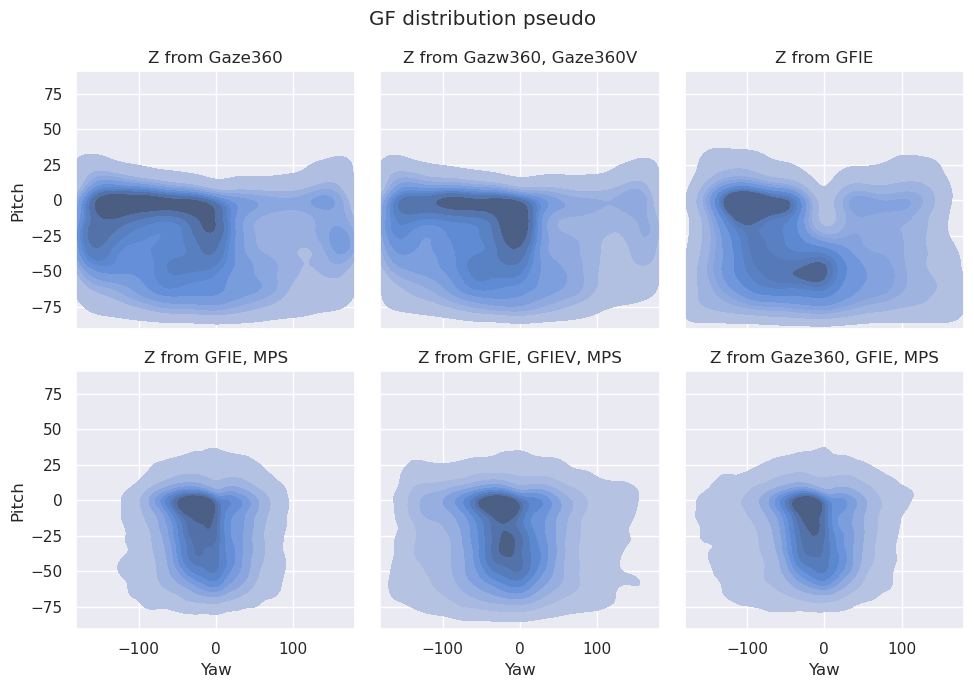

In [7]:
gf_paths = {
    'Gaze360': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360.pkl',
    'Gazw360, Gaze360V': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360_gaze360v.pkl',
    'GFIE': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie.pkl',
    'GFIE, MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie_mps.pkl',
    'GFIE, GFIEV, MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie_gfiev_mps.pkl',
    'Gaze360, GFIE, MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_360_gfie_mps.pkl'
}

# plot the gaze distribution of different datasets
fig, ax = plt.subplots(2, 3, figsize=(10,7) , sharex=True, sharey=True)
fig.suptitle('GF distribution pseudo') 
ax = ax.flatten()

for i, (k,v) in enumerate(gf_paths.items()):
    with open(v, 'rb') as f:
        pred_gaze = pickle.load(f)
    gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
    gaze_distribution = gaze_distribution.sample(50000)
    sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[i],fill=True)
    ax[i].set_title(f'Z from {k}')

plt.tight_layout()
ax[0].set_xlim(-181,181)
ax[0].set_ylim(-91,91)
fig.savefig('results/gaze_distribution_gf.png', dpi=300)
plt.show()

0
[[-163.3881695161865, -6.197603633238379], [14.195561474998522, -38.879025155096095], [-15.155836308910768, -14.431763891950295], [-75.57827503966514, -47.113082516812284], [177.13196545699387, -14.729725173152628], [-160.1133168633578, -18.62878058367343], [175.86898035699164, -21.494752853979833], [-142.2829385962045, -18.596513599168215], [57.167967959148996, -33.69495316676698], [3.634566220649689, -77.92668328066003]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

1
[[-135.13652170499566, -15.00005386654069], [11.064240747378438, -32.25090662405571], [-13.268019043417622, -12.729958018930725], [-73.57601494369003, -46.837522831665915], [168.9523294886246, -45.19547178374507], [-150.69693189668752, -25.874307231997157], [175.5915713959989, -22.792105162940462], [-148.64314891841593, -15.971210385498024], [43.55094742392617, -28.667822217492372], [2.854421371632053, -74.76852114206285]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

2
[[-103.19207636020556, -20.29545384375138], [18.358420404784564, -46.00058481746175], [-63.24430906314356, -41.313479807626855], [-67.82239016475268, -45.83022593393147], [124.1203055320618, -77.05286134884493], [-129.76593666800738, -37.297940230018845], [39.16359079959764, -73.84615509815656], [-140.1367233599374, -19.418919164218554], [49.36073788066586, -31.054858254927087], [2.2458589425599897, -70.9138397038492]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

3
[[-19.71374924858733, -7.301510361450113], [10.772246373885766, -31.571663442372405], [-35.109137475117166, -29.515113919490062], [-39.50802918804197, -35.26859418921821], [9.999816723183935, -42.37645475885831], [-104.03411571747586, -43.87291438861423], [22.42278285698301, -64.3789458144835], [-73.54061904844924, -27.809919503547032], [54.680292733456184, -32.922528310702525], [1.2478853520665392, -58.0929475501103]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

4
[[-66.66500054944116, -19.22751440396051], [6.922670560255686, -21.617771457773806], [-24.790786375646633, -22.427599418949423], [-43.084939470991486, -37.21115571266764], [69.22994880838121, -78.49456251829518], [-120.62356107151508, -40.456884057314134], [17.196967553177313, -58.25442513697853], [-109.59690990962301, -27.390550641966936], [41.21771177839974, -27.60446094642007], [1.4745747591987413, -62.214516197715355]]


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

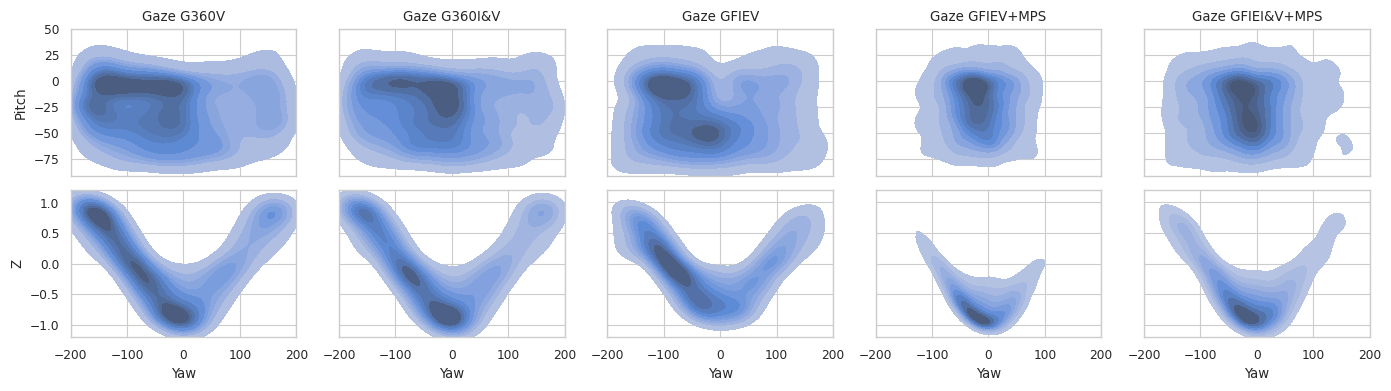

In [7]:
gf_paths = {
    'G360V': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360.pkl',
    'G360I&V': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gaze360_gaze360v.pkl',
    'GFIEV': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie.pkl',
    'GFIEV+MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie_mps.pkl',
    'GFIEI&V+MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_gfie_gfiev_mps.pkl',
    #'Gaze360, GFIE, MPS': '/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gazefollow/annotations/gaze_pseudo_omnivoreV_360_gfie_mps.pkl'
}

# plot the gaze distribution of different datasets
fig, ax = plt.subplots(2, 5, figsize=(14,4) , sharex=True, sharey='row')

for i, (k,v) in enumerate(gf_paths.items()):
    print(i)
    with open(v, 'rb') as f:
        pred_gaze = pickle.load(f)
    gaze_distribution = plot_gaze_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
    gaze_distribution = gaze_distribution.sample(5000)
    sns.kdeplot(gaze_distribution, x="Yaw", y="Pitch", ax=ax[0,i],fill=True)
    ax[0,i].set_title(f'Gaze {k}')
    ax[0,i].set_xlim(-200,200)
    ax[0,i].set_ylim(-91,50)    
    gaze_distribution = plot_gaze_yaw_z_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
    gaze_distribution = gaze_distribution.sample(5000)
    sns.kdeplot(gaze_distribution, x="Yaw", y="Z", ax=ax[1,i],fill=True)
    ax[1,i].set_ylabel('Z')
    ax[1,i].set_xlim(-200,200)
    ax[1,i].set_ylim(-1.2,1.2)
    # y axis off
for i in range(5):
    ax[1,i].set_xlabel('Yaw (degrees)')
    
ax[0,0].set_ylabel('Pitch (degrees)')
plt.tight_layout()
fig.savefig('results/gaze_distribution_gf.png', dpi=300)
plt.show()

/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

[[-19.031479918618135, -7.060849194548059], [11.218108891839115, -32.604540601087734], [-22.33432978993755, -20.508519634417084], [-41.765087142942875, -36.51795095716082], [17.194716451006894, -57.22622937387262], [-134.3537824014858, -35.321197749694164], [7.1157292220545685, -34.10496500505036], [-98.56658772549211, -28.54017218938677], [34.94396840403989, -24.442971341675094], [1.2235612284782404, -57.58479979487423]]


ValueError: Could not interpret value `Z` for parameter `y`

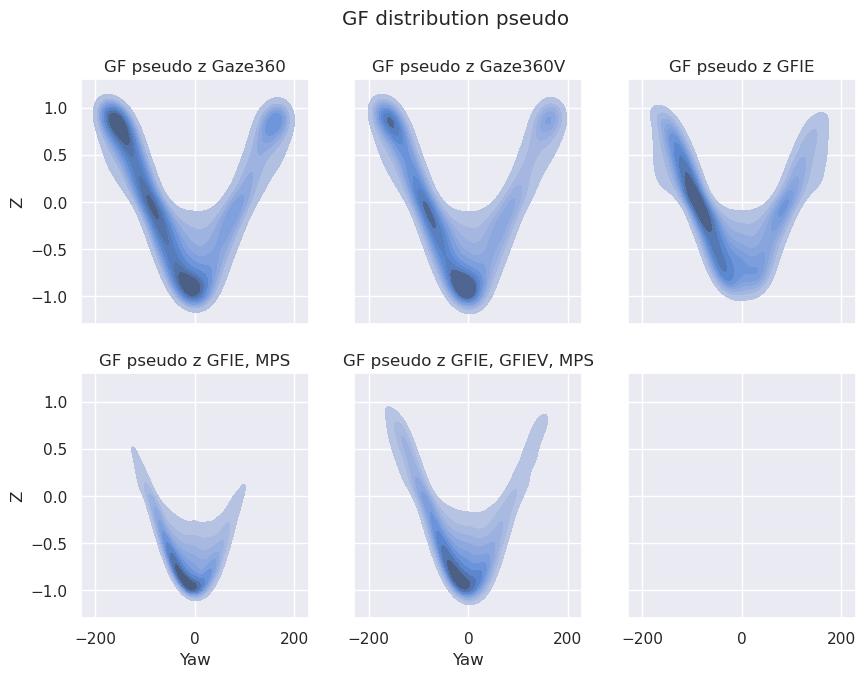

In [6]:
# plot the gaze Z distribution of different datasets
fig, ax = plt.subplots(2, 3, figsize=(10,7) , sharex=True, sharey=True)
fig.suptitle('GF distribution pseudo') 
ax = ax.flatten()
i = 0

for i, (k,v) in enumerate(gf_paths.items()):
    with open(v, 'rb') as f:
        pred_gaze = pickle.load(f)
    gaze_distribution = plot_gaze_yaw_z_distribution(pred_gaze, 'gaze_vector_pred', if_other=False)
    gaze_distribution = gaze_distribution.sample(50000)
    sns.kdeplot(gaze_distribution, x="Yaw", y="Z", ax=ax[i],fill=True)
    ax[i].set_title(f'Z from {k}')

plt.tight_layout()
ax[1].set_xlim(-181,181)
ax[1].set_ylim(-1.1,1.1)
fig.savefig('results/gaze_distribution_gf_z.png', dpi=300)
plt.show()

In [4]:
# plot the error distribution of different prediction on different datasets
def generate_error_distrib(pred_db):
    error_distrib =[]
    for k, v in pred_db.items():
        gaze_yaw_pitch = (cartesial2spherical(torch.tensor(v['frame_gt']).unsqueeze(0))[0]*180/np.pi).tolist()
        error_distrib.append([ gaze_yaw_pitch[0],gaze_yaw_pitch[1] , v['error'] ])

    yaw = np.linspace(-185,185, 100)
    pitch = np.linspace(-90, 90, 100)
    yaw_mesh, pitch_mesh = np.meshgrid(yaw, pitch)
    error = np.zeros_like(yaw_mesh)
    error_count = np.zeros_like(yaw_mesh)
    for i in range(len(error_distrib)):
        pitch_idx = np.argmin(np.abs(pitch - error_distrib[i][1]))
        yaw_idx = np.argmin(np.abs(yaw - error_distrib[i][0]))
        error[pitch_idx, yaw_idx] += error_distrib[i][2]
        error_count[pitch_idx, yaw_idx] += 1

    error = error / error_count
    error = np.clip(error, 0, 100)
    return { 'yaw': yaw_mesh , 'pitch': pitch_mesh, 'error': error }

def error_distplot(exp_results,title,list_to_plot = ['Gaze360', 'GFIE', 'GazeFollow', 'MPSGaze','Eyediap'], mode_angular = 'cartesian'):

    k = 2 if mode_angular == 'spherical' else 3
    exp_results['frame_pred'] = exp_results['frame_pred'].view(-1, k).numpy()
    exp_results['frame_gt'] = exp_results['frame_gt'].view(-1, k).numpy()
    exp_results['frame_id'] = exp_results['frame_id'].view(-1).numpy()
    exp_results['video_id'] = exp_results['video_id'].view(-1).numpy()
    exp_results['person_id'] = exp_results['person_id'].view(-1).numpy()
    exp_results['data_id'] = exp_results['data_id'].view(-1).numpy()

    # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl', 'rb') as f:
    #     image_db_gaze360 = pickle.load(f)
    
    # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl', 'rb') as f:
    #     image_db_gfie = pickle.load(f)
    
    # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/MPSGaze/mpsgaze_image_database.pkl', 'rb') as f:
    #     image_db_mpsgaze = pickle.load(f)
   
    # with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/gaze360_model/run_2024-06-19_11-13-54/logs/train/runs/run_0/prediction/pred_gaze_gazefollow.pkl', 'rb') as f:
    #     image_db_follow = pickle.load(f)

    # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Eyediap/eyediap_image_database.pkl', 'rb') as f:
    #     image_db_eyediap = pickle.load(f)
    
    prediction_dataset = {}
    #################################################################################################
    # Gaze360 TESTING
    #################################################################################################

    pred_gaze360 = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 1:
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}']['error'] = angular

    prediction_dataset['Gaze360'] = generate_error_distrib(pred_gaze360)

    pred_gaze360 = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 7:
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}']['error'] = angular
    
    prediction_dataset['Gaze360Video'] = generate_error_distrib(pred_gaze360)



    #################################################################################################
    # GFIE TESTING
    #################################################################################################
    pred_gfie = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 2:
            pred_gfie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_gfie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}']['error'] = angular
    prediction_dataset['GFIE'] = generate_error_distrib(pred_gfie)

    pred_gfie = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 8:
            pred_gfie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_gfie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}']['error'] = angular
    prediction_dataset['GFIEVideo'] = generate_error_distrib(pred_gfie)

    #################################################################################################
    # GazeFollow TESTING
    #################################################################################################
    pred_follow = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 4:
            pred_follow[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_follow[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}']['error'] = angular

    prediction_dataset['GazeFollow'] = generate_error_distrib(pred_follow)

    #################################################################################################
    # MPSGAZE TESTING
    #################################################################################################
    pred_mpsgaze = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 3:
            pred_mpsgaze[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_mpsgaze[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}']['error'] = angular
    prediction_dataset['MPSGaze'] = generate_error_distrib(pred_mpsgaze)

    #################################################################################################
    # Eyediap TESTING
    #################################################################################################
    pred_eyediap = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 6:
            pred_eyediap[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i],
            }
            pred = torch.from_numpy(exp_results['frame_pred'][i]).unsqueeze(0)
            target = torch.from_numpy(exp_results['frame_gt'][i]).unsqueeze(0)
            angular = compute_angular_error_cartesian(pred,target).tolist()
            pred_eyediap[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}']['error'] = angular
            
    prediction_dataset['Eyediap'] = generate_error_distrib(pred_eyediap)
    #################################################################################################
    # create a heat map of the error distribution
    #################################################################################################
    fig, ax = plt.subplots(2, 3, figsize=(12,7) , sharex=True, sharey=True)
    fig.suptitle(title)
    ax = ax.flatten()
    plot_id = 0
    for i, (k, v) in enumerate(prediction_dataset.items()):
        if k in list_to_plot:
            mesh = ax[plot_id].pcolormesh(v['yaw'], v['pitch'], v['error'], cmap='gist_rainbow')
            ax[plot_id].set_title(k)
            ax[plot_id].set_xlabel('Yaw')
            ax[plot_id].set_ylabel('Pitch')
            plot_id +=1
    
    fig.colorbar(mesh, ax=ax.tolist())
    mesh.set_clim(0, 70)
    fig.savefig(f'results/error_distribution_{"_".join(title.split(" "))}.png',dpi = 300)
    plt.show()


    

/tmp/ipykernel_2157925/151209549.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


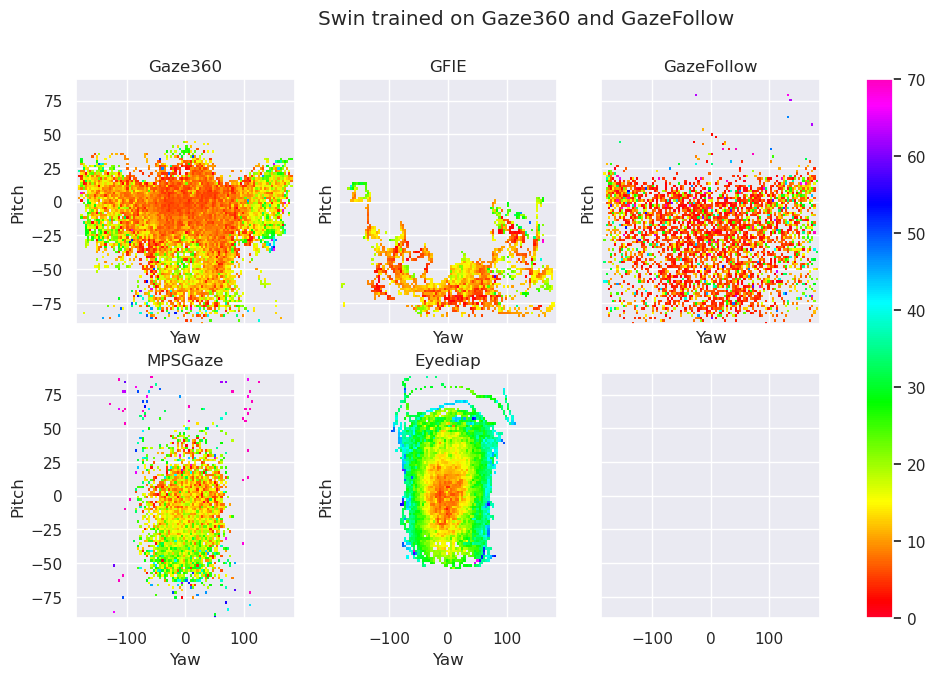

In [75]:
# trained on gaze360 and gaze follow
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-06-27_15-03-32/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_38.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Swin trained on Gaze360 and GazeFollow')

/tmp/ipykernel_2157925/151209549.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


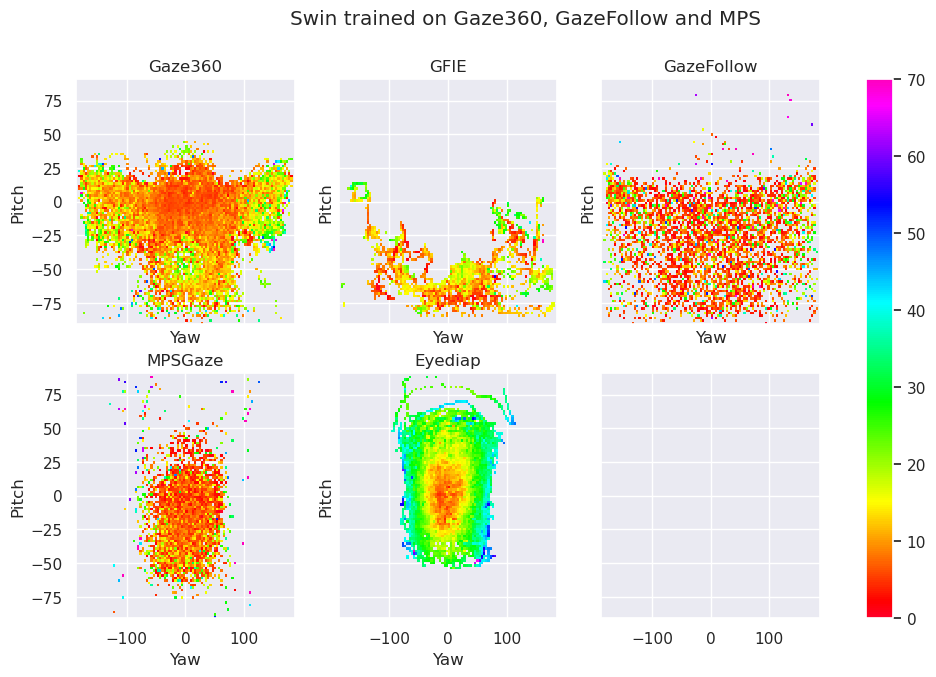

In [76]:
# model trained on gaze360 gaze follow and mps gaze
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-06-27_15-03-44/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_48.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Swin trained on Gaze360, GazeFollow and MPS')

/tmp/ipykernel_2157925/151209549.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


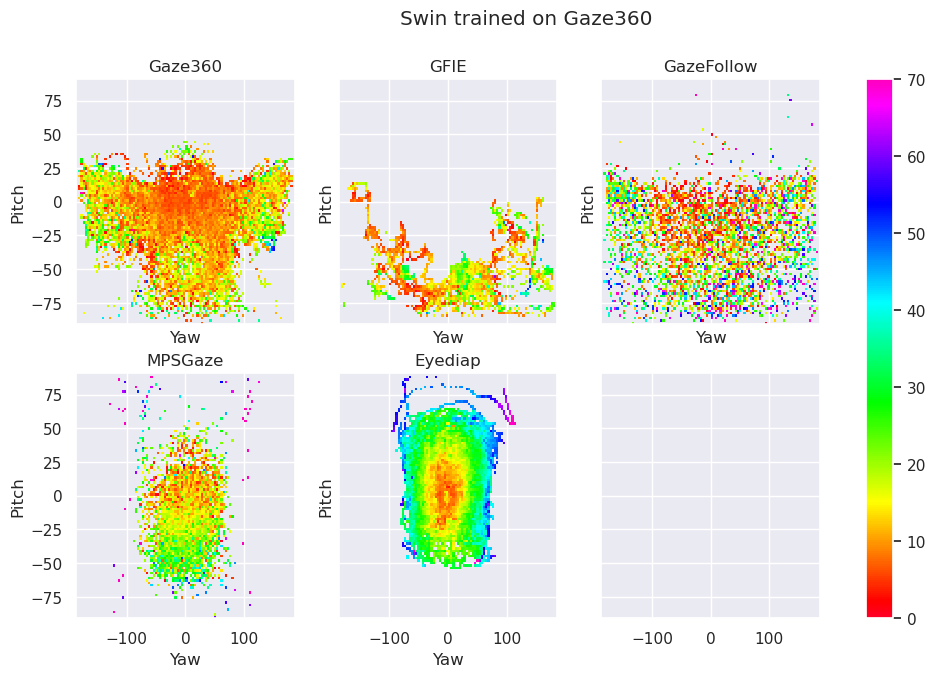

In [77]:
# model trained on gaze360 baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-06-27_15-01-30/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_50.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Swin trained on Gaze360')

### Omnivore experiment

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


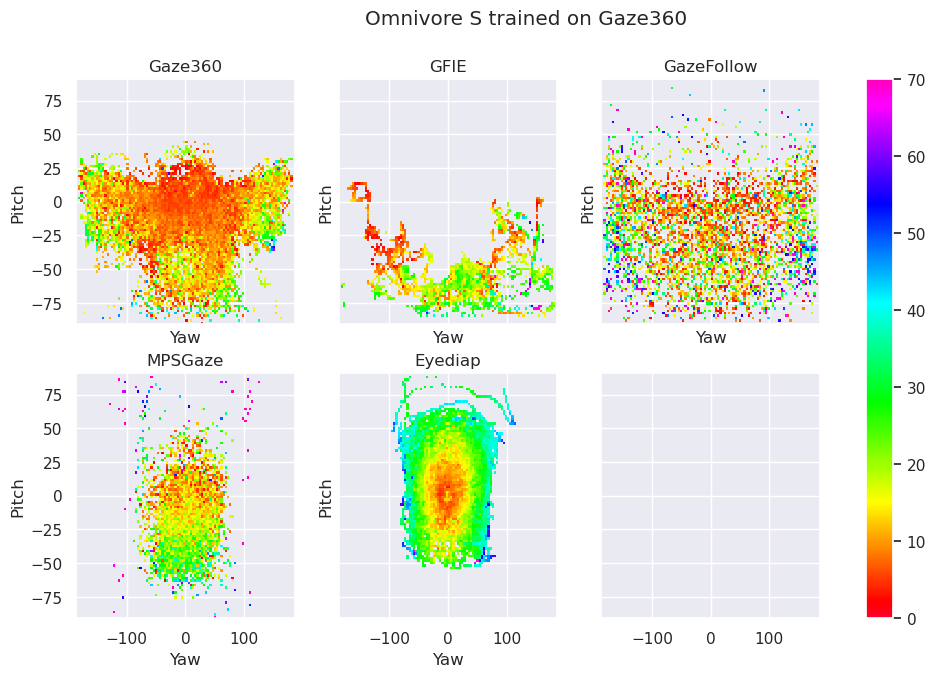

In [12]:
# Omnivore trained on gaze360 baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/omnivore/run_2024-07-03_12-50-08/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore S trained on Gaze360', list_to_plot = ['Gaze360', 'GFIE', 'GazeFollow', 'MPSGaze','Eyediap'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


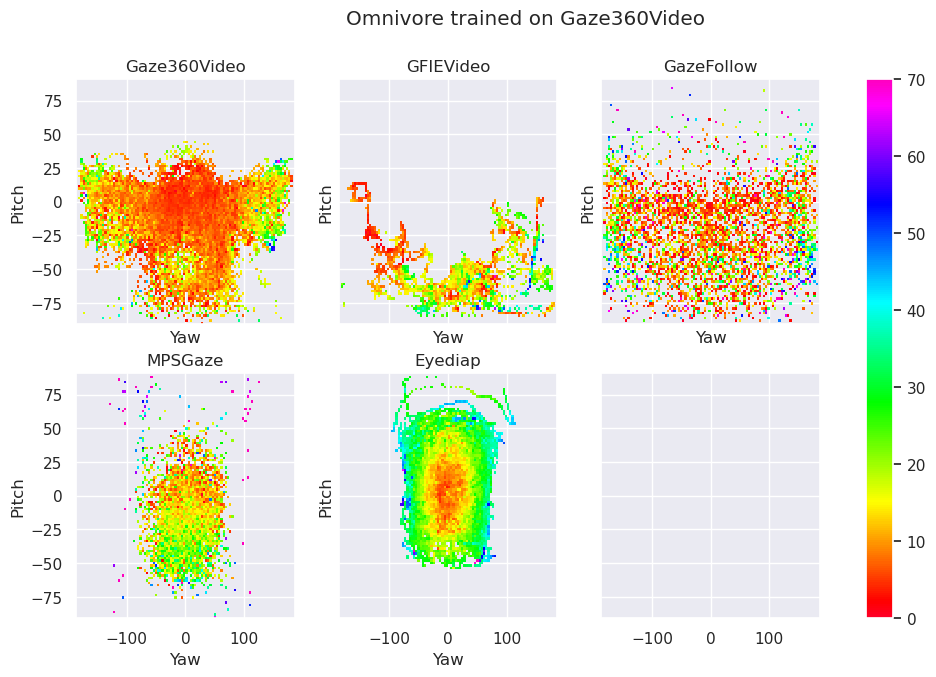

In [9]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/omnivore/run_2024-07-03_14-25-02/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on Gaze360Video', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


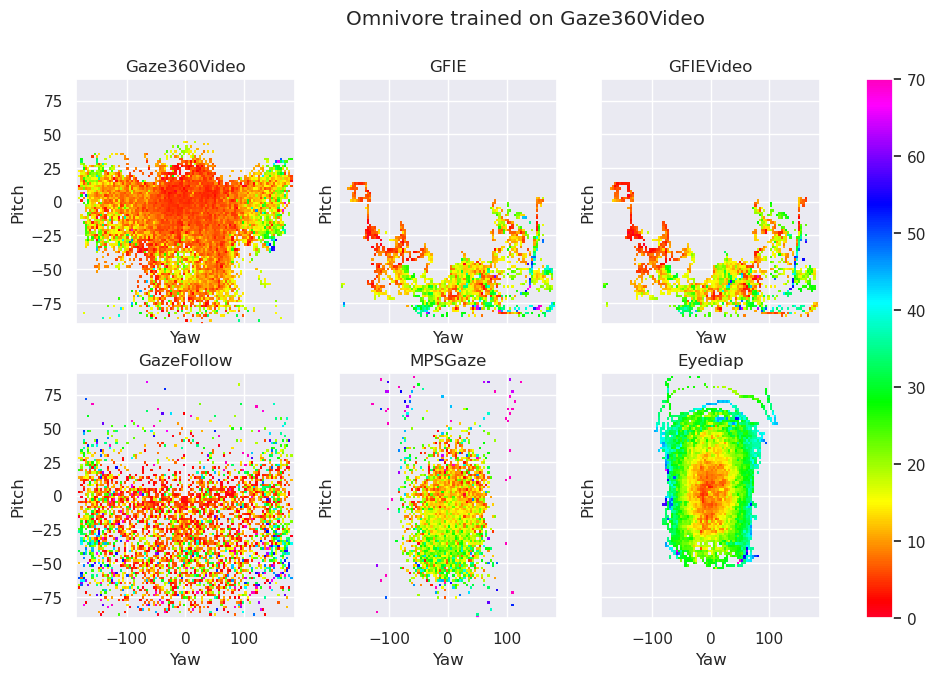

In [13]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/omnivore/run_2024-07-03_14-25-02/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on Gaze360Video', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap','GFIE'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


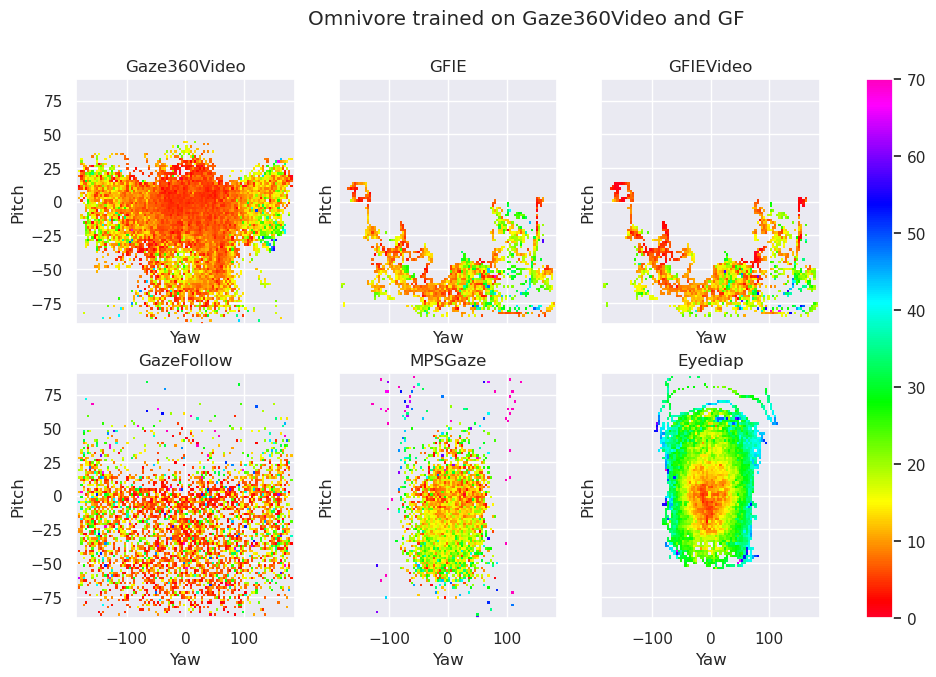

In [11]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_17-42-47/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on Gaze360Video and GF', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


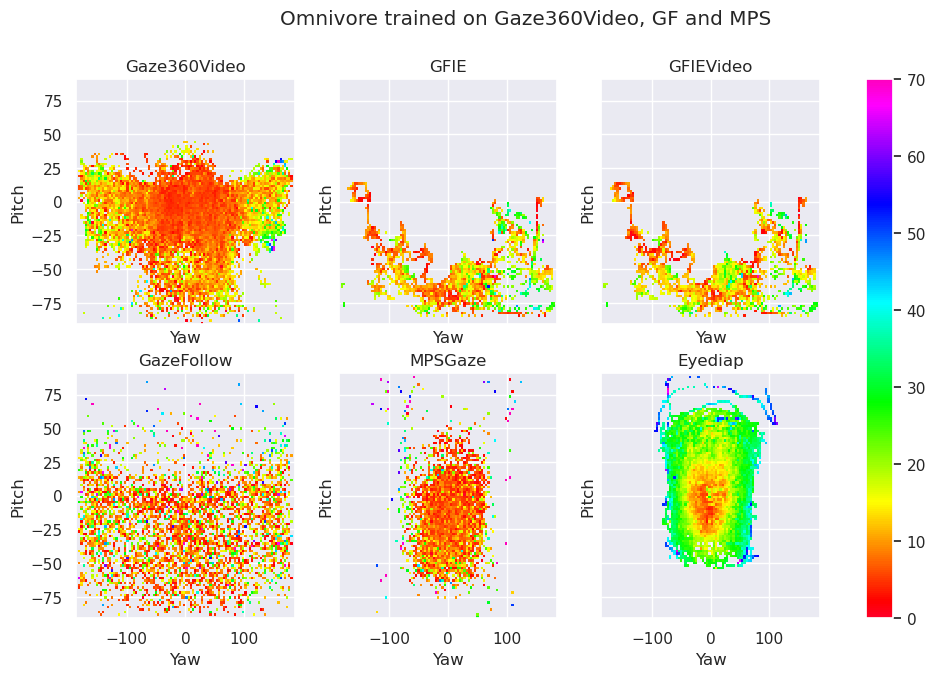

In [14]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_17-43-42/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on Gaze360Video, GF and MPS', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


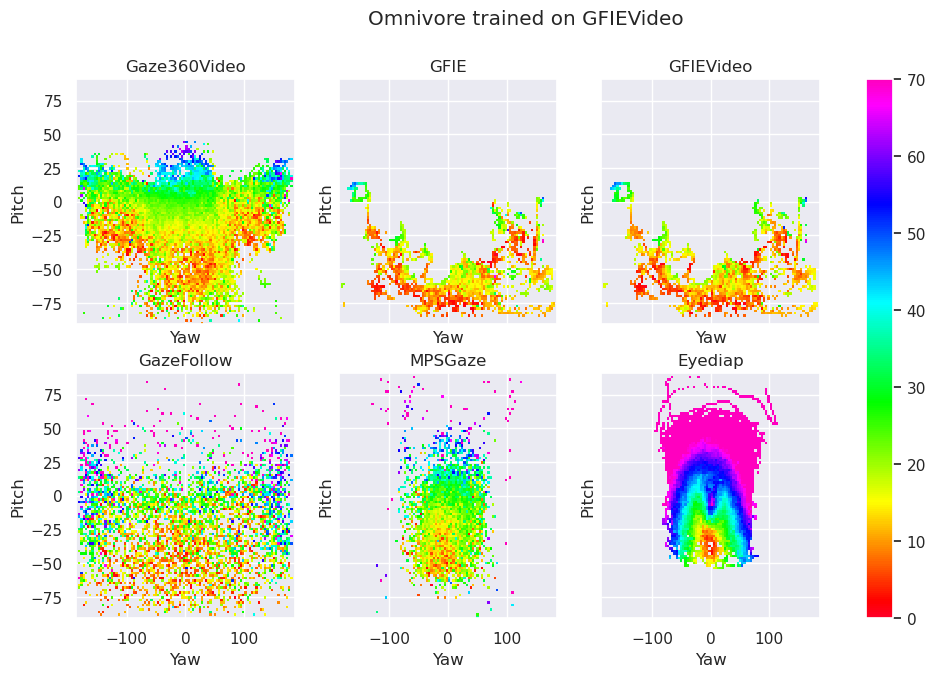

In [15]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_17-41-31/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on GFIEVideo', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )

/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


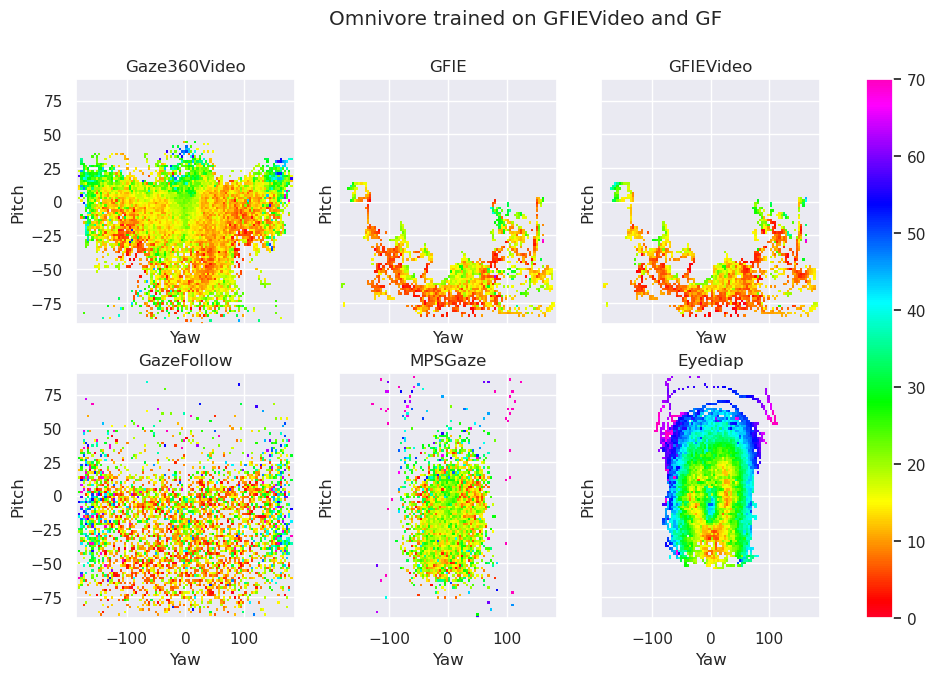

In [16]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_23-42-08/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on GFIEVideo and GF', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )


/tmp/ipykernel_2486708/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


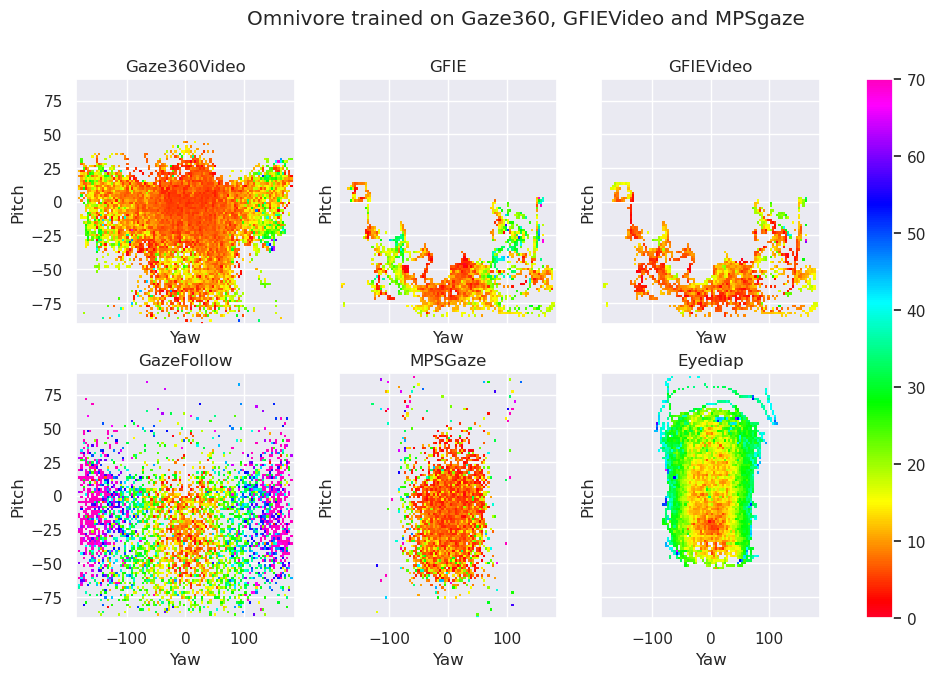

In [17]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_18-17-46/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_0.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on Gaze360, GFIEVideo and MPSgaze', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )
/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-05_17-49-15/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_50.pkl

/tmp/ipykernel_2547218/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


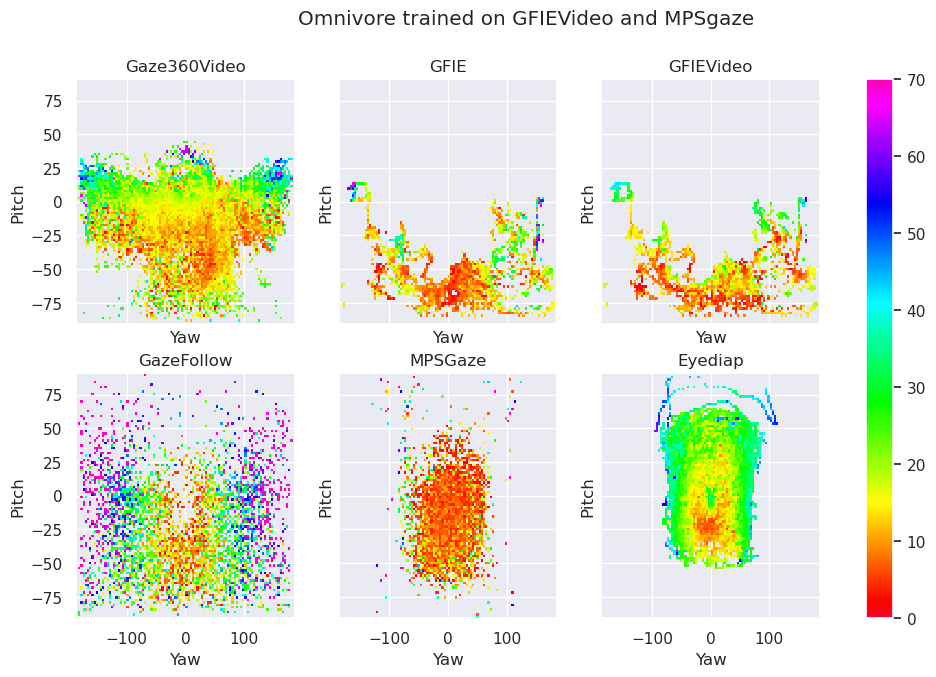

In [5]:
#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-05_17-49-15/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_50.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on GFIEVideo and MPSgaze', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )


/tmp/ipykernel_2740329/2785801461.py:19: RuntimeWarning: invalid value encountered in divide
  error = error / error_count


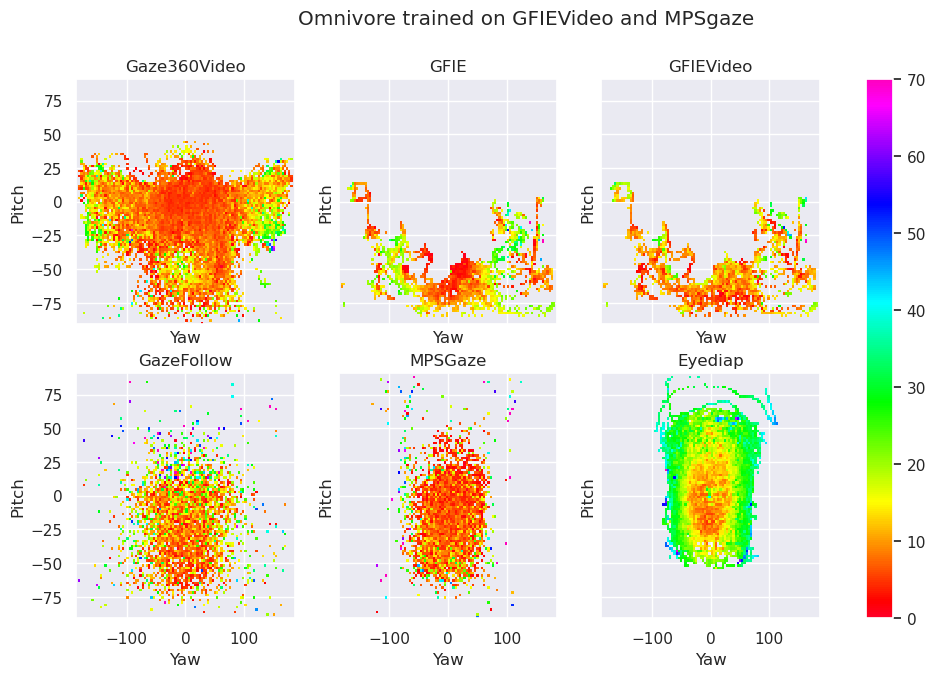

In [5]:

#Omnivore  trained on gaze360V baseline
with open('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-07_11-01-56/logs/train/runs/run_0/metric/test/prediction_test_gaze_epoch_50.pkl', 'rb') as f:
    exp_results = pickle.load(f)

error_distplot(exp_results,'Omnivore trained on GFIEVideo and MPSgaze', list_to_plot = ['Gaze360Video', 'GFIEVideo', 'GazeFollow', 'MPSGaze','Eyediap', 'GFIE'] )

In [4]:
# check the checkpoint of the sav3e emmoel form pythorch lygting
path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-06-30_14-28-18/logs/train/runs/run_0/checkpoints/best_epoch_028.ckpt'

dict_save = torch.load(path, map_location='cpu')

In [8]:
dict_save['state_dict'].keys() 
# filter only take the one that start with net
dict_save['state_dict'] = {k: v for k, v in dict_save['state_dict'].items() if k.startswith('net')}


odict_keys(['net.encoder.model.features.0.0.weight', 'net.encoder.model.features.0.0.bias', 'net.encoder.model.features.0.2.weight', 'net.encoder.model.features.0.2.bias', 'net.encoder.model.features.1.0.norm1.weight', 'net.encoder.model.features.1.0.norm1.bias', 'net.encoder.model.features.1.0.attn.logit_scale', 'net.encoder.model.features.1.0.attn.relative_coords_table', 'net.encoder.model.features.1.0.attn.relative_position_index', 'net.encoder.model.features.1.0.attn.qkv.weight', 'net.encoder.model.features.1.0.attn.qkv.bias', 'net.encoder.model.features.1.0.attn.proj.weight', 'net.encoder.model.features.1.0.attn.proj.bias', 'net.encoder.model.features.1.0.attn.cpb_mlp.0.weight', 'net.encoder.model.features.1.0.attn.cpb_mlp.0.bias', 'net.encoder.model.features.1.0.attn.cpb_mlp.2.weight', 'net.encoder.model.features.1.0.norm2.weight', 'net.encoder.model.features.1.0.norm2.bias', 'net.encoder.model.features.1.0.mlp.0.weight', 'net.encoder.model.features.1.0.mlp.0.bias', 'net.encoder.

In [3]:
import torch 

model = torch.hub.load("facebookresearch/omnivore", model="omnivore_swinT")

Using cache found in /idiap/temp/pvuillecard/library/torch/hub/facebookresearch_omnivore_main
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400412039/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/omnivore/models/swinT_checkpoint.torch" to /idiap/temp/pvuillecard/library/torch/hub/checkpoints/swinT_checkpoint.torch
100%|██████████| 125M/125M [00:05<00:00, 22.0MB/s] 


In [9]:
# test loading weight
omivore = torch.hub.load("facebookresearch/omnivore", model="omnivore_swinT")
ckpt = torch.load('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_17-43-42/logs/train/runs/run_0/checkpoints/best_epoch_018.ckpt', map_location='cpu')
# path = '/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_18-17-46/logs/train/runs/run_0/checkpoints/best_epoch_027.ckpt'
# with open(path, 'rb') as f:
#     ckpt = pickle.load(f)

# torch.load('/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/generalize/run_2024-07-04_18-17-46/logs/train/runs/run_0/checkpoints/best_epoch_027.ckpt', map_location='cpu')


Using cache found in /idiap/temp/pvuillecard/library/torch/hub/facebookresearch_omnivore_main


In [10]:
state_dict = ckpt['state_dict']
print(state_dict.keys())

odict_keys(['net.encoder.model.patch_embed.proj.weight', 'net.encoder.model.patch_embed.proj.bias', 'net.encoder.model.patch_embed.norm.weight', 'net.encoder.model.patch_embed.norm.bias', 'net.encoder.model.depth_patch_embed.proj.weight', 'net.encoder.model.depth_patch_embed.proj.bias', 'net.encoder.model.depth_patch_embed.norm.weight', 'net.encoder.model.depth_patch_embed.norm.bias', 'net.encoder.model.layers.0.blocks.0.norm1.weight', 'net.encoder.model.layers.0.blocks.0.norm1.bias', 'net.encoder.model.layers.0.blocks.0.attn.relative_position_bias_table', 'net.encoder.model.layers.0.blocks.0.attn.relative_position_index', 'net.encoder.model.layers.0.blocks.0.attn.qkv.weight', 'net.encoder.model.layers.0.blocks.0.attn.qkv.bias', 'net.encoder.model.layers.0.blocks.0.attn.proj.weight', 'net.encoder.model.layers.0.blocks.0.attn.proj.bias', 'net.encoder.model.layers.0.blocks.0.norm2.weight', 'net.encoder.model.layers.0.blocks.0.norm2.bias', 'net.encoder.model.layers.0.blocks.0.mlp.fc1.weig

In [ ]:
# save model weight as pickle 
import pickle
with open('/idiap/temp/pvuillecard/library/models/omnivoreT_gaze360v_mps_gf.pkl', 'wb') as f:
    pickle.dump(state_dict, f)